In [ ]:
"""
NAME: Keenan Samway
DATE: May, 2021
CLASS: GBUS 401 Big Data in Business, Economy, Society
ASSIGNMENT: Final Project
"""

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import glob

import collections
import random
import os

import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.metrics import top_k_categorical_accuracy

In [2]:
# Change to working directory that contains 'weco.csv'
%cd '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/'
!ls

/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr
 AIguessr.gdoc
 AIguessr.ipynb
 AIguessr_Trained_Model_1_Dense_33.h5
 AIguessr_Trained_Model_1_Res_45.h5
 AIguessr_Trained_Model_2_Dense_38.h5
 AIguessr_Trained_Model_2_Res_47.h5
 AIguessr_Trained_Model_2_Res_49.h5
 AIguessr_Trained_Model_3_Res_42.h5
 AIguessr_Trained_Model_4-1_Res_.h5
 AIguessr_Trained_Model_4_Dense_13.h5
 AIguessr_Trained_Model_4_Res_27.h5
 ca_county19
 cb_2019_us_county_500k
 co_county19
'Copy of AIguessr_Trained_Model_2-1_Res_.h5'
 createModel.ipynb
'Design Document.gdoc'
 generateMap.ipynb
 getImages.ipynb
 Images
 us_county19


In [101]:
IMG_SIZE = 256 # Raw images are 600x600
coloradoDir = '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/Images/Colorado/TTV'

# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
datagen = image.ImageDataGenerator( 
    preprocessing_function=preprocess_input, 
    horizontal_flip=True )

train_generator = datagen.flow_from_directory( 
    coloradoDir + '/train',
    target_size=( IMG_SIZE, IMG_SIZE ),
    batch_size=32,
    class_mode='categorical' )

test_generator = datagen.flow_from_directory( 
    coloradoDir + '/test',
    target_size=( IMG_SIZE, IMG_SIZE ),
    batch_size=32,
    class_mode='categorical' )

validation_generator = datagen.flow_from_directory( 
    coloradoDir + '/validation',
    target_size=( IMG_SIZE, IMG_SIZE ),
    batch_size=32,
    class_mode='categorical')

Found 7680 images belonging to 64 classes.
Found 2560 images belonging to 64 classes.
Found 2560 images belonging to 64 classes.


In [147]:
# Define DenseNet121 model for transfer learning
densenet = DenseNet121( input_shape=( IMG_SIZE, IMG_SIZE, 3 ),
                             weights='imagenet',
                             include_top=False )

29089792/29084464 [==============================] - 0s 0us/step


In [102]:
# Define ResNet50 model for transfer learning
# https://cv-tricks.com/keras/understand-implement-resnets/
resnet = ResNet50( input_shape=( IMG_SIZE, IMG_SIZE, 3),
                        weights='imagenet',
                        include_top=False )

In [47]:
# Define model 1
# STIA 415 Exercise 13
def create_model1( base_model ):
    model = models.Sequential()
    model.add( base_model )

    model.add( GlobalAveragePooling2D() )
    model.add( Dense( 100, activation='relu' ) )
    model.add( Dense( 64, activation='softmax' ) )

    return model

In [48]:
# Define model 2
# https://medium.com/@upendravijay2/how-does-dropout-help-to-avoid-overfitting-in-neural-networks-91b90fd86b20

def create_model2( base_model ):
    model = models.Sequential()
    model.add( base_model )
    model.add( GlobalAveragePooling2D() )

    model.add( BatchNormalization() )
    model.add( Dense( 256, activation='relu' ) )
    model.add( Dropout( 0.5 ) )

    model.add( BatchNormalization() )
    model.add( Dense( 128, activation='relu' ) )
    model.add( Dropout( 0.5 ) )

    model.add( Dense( 64, activation='softmax' ) )

    return model

In [49]:
# Define model 2-1
# https://medium.com/@upendravijay2/how-does-dropout-help-to-avoid-overfitting-in-neural-networks-91b90fd86b20

def create_model2_1( base_model ):
    model = models.Sequential()
    model.add( base_model )
    model.add( GlobalAveragePooling2D() )

    model.add( BatchNormalization() )
    model.add( Dense( 512, activation='relu' ) )
    model.add( Dropout( 0.5 ) )

    model.add( BatchNormalization() )
    model.add( Dense( 128, activation='relu' ) )
    model.add( Dropout( 0.5 ) )

    model.add( Dense( 64, activation='softmax' ) )

    return model

In [51]:
# Define model 4

def create_model4( base_model ):
    model = models.Sequential()
    model.add( base_model )
    model.add( GlobalMaxPool2D() )

    #model.add( BatchNormalization() )
    model.add( Dense( 128, activation='relu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense( 64, activation='softmax' ) )

    return model

In [61]:
# Define model 4_1

def create_model4_1( base_model ):
    model = models.Sequential()
    model.add( base_model )
    model.add( GlobalMaxPool2D() )

    model.add( BatchNormalization() )
    model.add( Dense( 128, activation='relu' ) )
    model.add( Dropout( 0.5 ) )

    model.add( Dense( 64, activation='softmax' ) )

    return model

In [103]:
# Define model 4_2

def create_model4_2( base_model ):
    model = models.Sequential()
    model.add( base_model )
    model.add( GlobalMaxPool2D() )

    model.add( BatchNormalization() )
    model.add( Dense( 512, activation='relu' ) )
    model.add( Dropout( 0.5 ) )

    model.add( Dense( 64, activation='softmax' ) )

    return model

In [125]:
# Define model 4_3

def create_model4_3( base_model ):
    model = models.Sequential()
    model.add( base_model )
    model.add( GlobalMaxPool2D() )

    model.add( BatchNormalization() )
    model.add( Dense( 512, activation='relu' ) )
    model.add( Dropout( 0.7 ) )

    model.add( Dense( 64, activation='softmax' ) )

    return model

In [148]:
# Define model 4_4

def create_model4_4( base_model ):
    model = models.Sequential()
    model.add( base_model )
    model.add( GlobalAveragePooling2D() )

    model.add( BatchNormalization() )
    model.add( Dense( 512, activation='relu' ) )
    model.add( Dropout( 0.7 ) )

    model.add( Dense( 64, activation='softmax' ) )

    return model

In [ ]:
# https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

"""
'AIguessr_Trained_Model_1_Dense_33.h5'
    - 600x600x3
    - DenseNet121
    - model 1
    - 30+ epochs (33%)

'AIguessr_Trained_Model_2_Dense_38.h5'
    - 256x256x3
    - DenseNet121
    - model 2
    - 20 epochs (38%)

'AIguessr_Trained_Model_1_Res_45.h5'
    - 256x256x3
    - ResNet50
    - model 1
    - 20 epochs (45%)

'AIguessr_Trained_Model_2_Res_30.h5'
    - 64x64x3
    - ResNet50
    - model 2
    - 20 epochs (30%)

AIguessr_Trained_Model_2_Res_38.h5
    - 128x128x3
    - ResNet50
    - model 2
    - 20 epochs (38%)

'AIguessr_Trained_Model_2_Res_47.h5'
'AIguessr_Trained_Model_2_Res_49.h5'
    - 256x256x3
    - ResNet50
    - model 2
    - 20 epochs (47%)
    - 40 epochs (49%)

'AIguessr_Trained_Model_2-1_Res_49.h5'
    - 256x256x3
    - Resnet50
    - model 2-1
    - 20 epochs (49%)

'AIguessr_Trained_Model_4-1_Res_35.h5'
    - 64x64x3
    - ResNet50
    - model 4-1
    - 20 epochs (35%)

'AIguessr_Trained_Model_4-1_Res_43.h5'
    - 128x128x3
    - ResNet50
    - model 4-1
    - 20 epochs (43%)

'AIguessr_Trained_Model_4-1_Res_47.h5'
    - 256x256x3
    - Resnet50
    - model 4-1
    - 20 epochs (47%)

'AIguessr_Trained_Model_4-2_Res_48.h5'
    - 128x128x3
    - ResNet50
    - model 4-2
    - 20 epochs (48%)

'AIguessr_Trained_Model_4-2_Res_52.h5'
    - 256x256x3
    - Resnet50
    - model 4-2
    - 20 epochs (52%)

'AIguessr_Trained_Model_4-3_Res_52.h5'
'AIguessr_Trained_Model_4-3_Res_53.h5'
    - 256x256x3
    - Resnet50
    - model 4-3
    - 20 epochs (52%)
    - 40 epochs (53%)

'AIguessr_Trained_Model_4-4_Res_54.h5'
    - 256x256x3
    - Resnet50
    - model 4-4
    - 20 epochs (54%)

'AIguessr_Trained_Model_4-4_Dense_49.h5'
    - 256x256x3
    - DenseNet121
    - model 4-4
    - 20 epochs (49%)
"""

In [149]:
# Create the model and output the summary
weights_filename = 'AIguessr_Trained_Model_4-4_Dense_.h5'

model = create_model4_4( densenet )

model.layers[0].trainable = False

#model.load_weights( weights_filename )

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_40 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                32832     
Total params: 7,599,232
Trainable params: 559,680
Non-trainable params: 7,039,552
_____________________________________

In [150]:
# Create callbacks list
checkpoint = ModelCheckpoint( weights_filename, monitor='val_accuracy', save_best_only=True )
early_stop = EarlyStopping( monitor='val_accuracy', patience=16 )
callbacks_list = [checkpoint, early_stop]

In [151]:
def top_3_accuracy( y_true, y_pred ):
    return top_k_categorical_accuracy( y_true, y_pred, k=3 )

def top_5_accuracy( y_true, y_pred ):
    return top_k_categorical_accuracy( y_true, y_pred, k=5 )

In [152]:
# Compile model
model.compile( optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', top_3_accuracy, top_5_accuracy] )

In [153]:
# Fit the model using the training generator and validate on the validation generator
history = model.fit( train_generator,
                    epochs=20,
                    validation_data=validation_generator, 
                    callbacks=callbacks_list )

Epoch 1/20
240/240 [==============================] - 81s 312ms/step - loss: 4.5186 - accuracy: 0.0661 - top_3_accuracy: 0.1398 - top_5_accuracy: 0.2093 - val_loss: 3.3320 - val_accuracy: 0.2176 - val_top_3_accuracy: 0.4000 - val_top_5_accuracy: 0.5109
Epoch 2/20
240/240 [==============================] - 74s 307ms/step - loss: 3.3697 - accuracy: 0.1746 - top_3_accuracy: 0.3421 - top_5_accuracy: 0.4460 - val_loss: 2.9399 - val_accuracy: 0.2754 - val_top_3_accuracy: 0.4832 - val_top_5_accuracy: 0.5945
Epoch 3/20
240/240 [==============================] - 73s 306ms/step - loss: 3.0183 - accuracy: 0.2308 - top_3_accuracy: 0.4317 - top_5_accuracy: 0.5388 - val_loss: 2.6884 - val_accuracy: 0.3215 - val_top_3_accuracy: 0.5359 - val_top_5_accuracy: 0.6426
Epoch 4/20
240/240 [==============================] - 76s 315ms/step - loss: 2.7720 - accuracy: 0.2796 - top_3_accuracy: 0.4869 - top_5_accuracy: 0.6015 - val_loss: 2.5044 - val_accuracy: 0.3508 - val_top_3_accuracy: 0.5727 - val_top_5_accur

In [154]:
# Evaluate the model on the test dataset

print( model.metrics_names )
model.evaluate( test_generator )

['loss', 'accuracy', 'top_3_accuracy', 'top_5_accuracy']
80/80 [==============================] - 19s 232ms/step - loss: 1.9415 - accuracy: 0.4945 - top_3_accuracy: 0.6984 - top_5_accuracy: 0.7762


[1.941528558731079, 0.4945312440395355, 0.698437511920929, 0.776171863079071]

In [ ]:
print( train_generator.class_indices )
label_dictionary = { v:k for k, v in train_generator.class_indices.items() }
print(label_dictionary)

{'08001': 0, '08003': 1, '08005': 2, '08007': 3, '08009': 4, '08011': 5, '08013': 6, '08014': 7, '08015': 8, '08017': 9, '08019': 10, '08021': 11, '08023': 12, '08025': 13, '08027': 14, '08029': 15, '08031': 16, '08033': 17, '08035': 18, '08037': 19, '08039': 20, '08041': 21, '08043': 22, '08045': 23, '08047': 24, '08049': 25, '08051': 26, '08053': 27, '08055': 28, '08057': 29, '08059': 30, '08061': 31, '08063': 32, '08065': 33, '08067': 34, '08069': 35, '08071': 36, '08073': 37, '08075': 38, '08077': 39, '08079': 40, '08081': 41, '08083': 42, '08085': 43, '08087': 44, '08089': 45, '08091': 46, '08093': 47, '08095': 48, '08097': 49, '08099': 50, '08101': 51, '08103': 52, '08105': 53, '08107': 54, '08109': 55, '08111': 56, '08113': 57, '08115': 58, '08117': 59, '08119': 60, '08121': 61, '08123': 62, '08125': 63}
{0: '08001', 1: '08003', 2: '08005', 3: '08007', 4: '08009', 5: '08011', 6: '08013', 7: '08014', 8: '08015', 9: '08017', 10: '08019', 11: '08021', 12: '08023', 13: '08025', 14: 

[[9.7740758e-03 1.1978063e-05 3.5835002e-03 4.7182803e-05 5.0988633e-06
  1.5896929e-06 2.3923995e-01 1.7662639e-02 4.8034817e-05 5.2345024e-07
  2.9197726e-02 1.6254830e-04 7.0735543e-05 3.7502909e-06 7.1839124e-05
  3.2342179e-04 9.7951092e-02 2.4061173e-06 1.1362317e-01 3.3639942e-03
  1.1823683e-04 1.2914467e-02 1.1624345e-03 6.4539765e-03 2.2705673e-01
  9.8439064e-05 1.8769428e-04 8.2981533e-05 1.3017010e-04 4.1138878e-06
  1.8958984e-01 7.6837273e-07 1.5596221e-06 1.0594502e-03 4.0919235e-04
  1.0971101e-02 1.7510906e-04 8.4650601e-06 1.6238839e-05 1.5217860e-03
  1.8930399e-05 1.9833931e-07 1.7003030e-04 2.8228291e-04 2.3293893e-05
  6.3851548e-05 2.1865286e-04 1.2336487e-04 2.4463714e-07 1.9471172e-03
  4.7204630e-05 9.9762529e-04 4.7683448e-06 1.4081389e-04 1.8929426e-05
  3.1863558e-05 2.3793082e-03 2.0251669e-04 1.0847911e-06 1.2697598e-02
  1.2853063e-02 2.0528186e-07 6.6868478e-04 4.6056465e-07]]
1st Predicted class: 08013, certainty: 0.23923994600772858


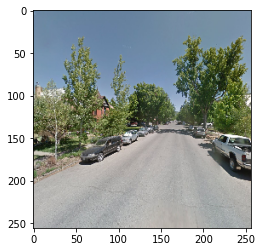

In [ ]:
testImgDir = '/content/drive/My Drive/- 2021 Spring/GBUS 401/AIguessr/Images/Colorado/Games'

testImage = testImgDir + '/Game 4/Colorado_5.JPG'

im = image.load_img( testImage, target_size=(IMG_SIZE,IMG_SIZE,3) )
plt.imshow( im )

# Preprocess image (normalization, etc; this is bespoke for DenseNet)
im_array = image.img_to_array(im)
im_array = np.expand_dims(im_array, axis=0)
im_array = preprocess_input(im_array)

preds = model.predict( im_array )
print( preds )

predicted_class = np.argmax( preds[0] )
print( "1st Predicted class: {}, certainty: {}".format( label_dictionary[predicted_class], preds[0][predicted_class] ) )

In [ ]:
index = np.array( range( len( preds ) ) )

new_order = preds.argsort()
predsOrdered = preds[new_order]
index = index[new_order]

predicted_class2 = predsOrdered[-2]
print( "2nd Predicted class: {}, certainty: {}".format( label_dictionary[predicted_class2], predsOrdered[0][predicted_class2] ) )

predicted_class3 = predsOrdered[-3]
print( "3rd Predicted class: {}, certainty: {}".format( label_dictionary[predicted_class3], predsOrdered[0][predicted_class3] ) )


In [ ]:
"""
Game 3
Loss = 1.9549354314804077
Accuracy = 0.4703125059604645
https://www.geoguessr.com/challenge/7GbGL3IJ0EFTuBqg
Camera pointed north
Location 1: Predicted class: 08063, certainty: 0.5547596216201782
Location 2: Predicted class: 08055, certainty: 0.4535605013370514
Location 3: Predicted class: 08031, certainty: 0.2181747555732727
Location 4: Predicted class: 08095, certainty: 0.5193750858306885
Location 5: Predicted class: 08013, certainty: 0.23923994600772858
Result: 
"""

In [ ]:
"""
Game 3
Loss = 2.1972365379333496
Accuracy = 0.45820313692092896
https://www.geoguessr.com/challenge/7GbGL3IJ0EFTuBqg
Camera pointed north
Location 1: Predicted class: 08063, certainty: 0.5127987265586853 - 51 miles - 1,675 pts
Location 2: Predicted class: 08035, certainty: 0.3229822814464569 - 150 miles - 201 pts
Location 3: Predicted class: 08041, certainty: 0.2889745831489563 - 49 miles - 1,734 pts
Location 4: Predicted class: 08095, certainty: 0.37820765376091003 - 120 miles - 383 pts
Location 5: Predicted class: 08031, certainty: 0.2549901306629181 - 233 miles - 34 pts
Result: 604 miles - 4,027 pts - https://www.geoguessr.com/results/7GbGL3IJ0EFTuBqg
"""

In [ ]:
"""
Game 3
Loss = 2.1972365379333496
Accuracy = 0.45820313692092896
https://www.geoguessr.com/challenge/z92b4uTxYt6dWPme
Camera pointed north
Location 1: Predicted class: 08031, certainty: 0.8628458380699158 - 63 miles - 1,300 pts
Location 2: Predicted class: 08035, certainty: 0.6470686197280884 - 73 miles - 1,043 pts
Location 3: Predicted class: 08055, certainty: 0.2780340909957886 - 14 miles - 3,737 pts
Location 4: Predicted class: 08021, certainty: 0.3073798418045044 - 107 miles - 503 pts
Location 5: Predicted class: 08081, certainty: 0.9645105004310608 - 29 nmiles - 2,695 pts
Result: 286 miles - 9,276 pts - https://www.geoguessr.com/results/z92b4uTxYt6dWPme
"""

In [ ]:
"""
Game 2
DenseNet121
Loss = 2.4923224449157715
Accuracy = 0.3304687440395355
https://www.geoguessr.com/challenge/hxPgmfAaXaUWZvnb
Camera pointed north
Location 1: Predicted class: 08095, certainty: 0.6119208931922913 - 78 miles
Location 2: Predicted class: 08035, certainty: 0.7991230487823486 - 87 miles
Location 3: Predicted class: 08099, certainty: 0.3755357265472412 - 336 miles
Location 4: Predicted class: 08097, certainty: 0.34768348932266235 - 41 miles
Location 5: Predicted class: 08035, certainty: 0.3185417950153351 - 191 miles
Result: 733 miles - 3,894 pts - https://www.geoguessr.com/results/hxPgmfAaXaUWZvnb
"""

In [ ]:
"""
Game 1
DenseNet121
Loss = 2.4923224449157715
Accuracy = 0.3304687440395355
https://www.geoguessr.com/challenge/ieu5NwV7APLHLKOV
Rotated camera to different angles
Location 1: Predicted class: 08037, certainty: 0.5132981538772583 - 62 miles
Location 2: Predicted class: 08005, certainty: 0.390635222196579 - 84 miles
Location 3: Predicted class: 08005, certainty: 0.25245288014411926 - 26 miles
Location 4: Predicted class: 08021, certainty: 0.7579935193061829 - 155 miles
Location 5: Predicted class: 08007, certainty: 0.24159245193004608 - 26 miles
Result: 352 miles - 8,088 pts - https://www.geoguessr.com/results/ieu5NwV7APLHLKOV
"""

In [ ]:
"""
Game 
Loss = 
Accuracy = 

Camera pointed north
Location 1: 
Location 2: 
Location 3: 
Location 4: 
Location 5: 
Result: 
"""

In [ ]:
"""
Other Colorado Maps

https://www.geoguessr.com/maps/5b240fe3f65f8d3f044984ba - 480 ppl - 9,324 avg pts
https://www.geoguessr.com/maps/5b770b429505793ab8a84860 - 370 ppl - 9,655 avg pts
https://www.geoguessr.com/maps/5e26168a6ea51084bc3cd57a - 020 ppl - 6,427 avg pts
"""